# Data generation notebook.
This notebook will (re)generate the packaged data.  
This data comprises two simulated fMRS datasets (with and without stimulation) from each of 10 subjects.
Each dataset comprises 64 spectra with two blocks of stimulation and two blocks of rest, in the pattern (REST-STIM-REST-STIM).

The data is modelled per metabolite with Glutamate, Lactate, and Glucose following the same pattern
Glutamate = 4±1.3% rise during STIM
Lactate = 25±23% rise during STIM
Glucose = -16±18% drop during STIM
Aspartate delayed negative response:
Aspartate = -5±4% drop during STIM

All other metabolites are constant w.r.t STIM.
Random linear drift term of up to ±5% applied to each metabolite.

A gaussian linewidth narrowing of 0.5 Hz during STIM following the HRF is applied to all metabolites.

Control data has no changes during STIM, nor linewidth changes, but does have a random linear drift term.

The simulated data complex noise noise added which has a per-subject standard deviation.

A random seed has been set to ensure that the data generated each time is identical.

In [75]:
import pandas as pd

df_bednarik = pd.read_csv('bednarik_table_1.csv', index_col=0)
df_bednarik

,Conc,Conc SEM,Conc SD,Change (%),Change (conc),Change SEM,Change SD
Metabolite,,,,,,,
Asc,0.96,0.04,0.15,-4.3,-0.05,0.03,0.12
Asp,3.58,0.15,0.58,-5.4,-0.20,0.04,0.15
Cr,4.22,0.10,0.39,1.0,0.04,0.02,0.08
GABA,1.03,0.09,0.35,3.7,0.02,0.03,0.12
Glc,0.62,0.14,0.54,-16.0,-0.19,0.03,0.12
Gln,2.79,0.12,0.46,1.2,0.03,0.02,0.08
Glu,8.59,0.15,0.58,3.3,0.28,0.03,0.12
GPC,0.54,0.02,0.08,1.7,0.01,0.01,0.04
GSH,1.09,0.03,0.12,2.8,0.03,0.02,0.08


{'Asc': 0.96, 'Asp': 3.58, 'Cr': 4.22, 'GABA': 1.03, 'Glc': 0.62, 'Gln': 2.79, 'Glu': 8.59, 'GPC': 0.54, 'GSH': 1.09, 'Lac': 1.01, 'Ins': 6.08, 'NAA': 11.9, 'NAAG': 1.32, 'PCh': 0.4, 'PCr': 3.34, 'PE': 0.93, 'Scyllo': 0.27, 'Tau': 1.27, 'Mac': 7.0}


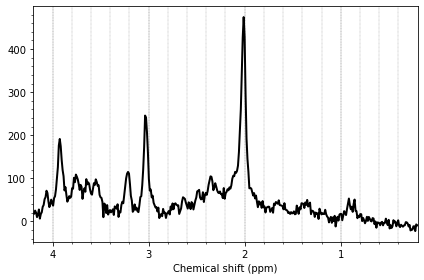

In [226]:
from fsl_mrs.utils import mrs_io
from fsl_mrs.utils import synthetic as syn
def gen_spectrum(concs, gamma, sigma, noise_var):
    fid, empty_mrs, _ = syn.syntheticFromBasisFile(
        'basis',
        metab_groups=['Mac'],
        ind_scaling=['Mac'],
        concentrations=concs,
        baseline=[0, 0],
        broadening= [(gamma, sigma), (0, sigma)],
        noisecovariance=[[noise_var]],
        bandwidth=3000, points=1024)
    empty_mrs.FID = fid
    return empty_mrs

test_dict = df_bednarik.Conc.to_dict()
test_dict['Mac'] = 7.0
print(test_dict)
mrs = gen_spectrum(test_dict, 25, 15, 50)
mrs.plot()


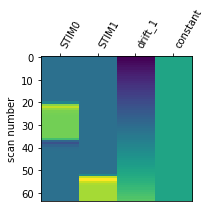

In [227]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt

# Calculations to create the design matrix
tr          = 4.0  # repetition time in seconds
n_blocks    = 2  # Number of stimulation blocks
n_scans     = 64  # Total number of scan points (128)
frame_times = np.arange(n_scans) * tr  # Time point of each data point
conditions  = [f'STIM{i}' for i in range(n_blocks)] # each trial gets its own regressor
duration    = [16.*tr,] * n_blocks # Duration of each stimulation block
onsets = [tr*15.+tr*32.*k for k in np.arange(0, n_blocks)] # Start time of each stimulation block.
events = pd.DataFrame({'trial_type': conditions, 
                       'onset'     : onsets,
                       'duration'  : duration})

# Pass to nilearn function to create design matrix
design_matrix = make_first_level_design_matrix(
    frame_times,
    events,
    drift_model='polynomial',
    drift_order=1, 
    hrf_model='glover') 

events_delayed = pd.DataFrame({'trial_type': conditions, 
                       'onset'     : [tr*19.+tr*32.*k for k in np.arange(0, n_blocks)],
                       'duration'  : duration})


design_matrix_delayed = make_first_level_design_matrix(
    frame_times,
    events_delayed,
    drift_model='polynomial',
    drift_order=1, 
    hrf_model='glover')

# Plot the designmatrix for inspection
fig = plt.figure(figsize=(3,3))
_ = plot_design_matrix(design_matrix_delayed, ax=fig.gca())

In [228]:
import numpy as np
from fsl_mrs.core.nifti_mrs import gen_new_nifti_mrs
basis = mrs_io.read_basis('basis')

# Calculate concnetrations 
def gen_subject_data(subject_df):
    sub_concs = {}
    for met in basis.names:
        curr_betas = np.asarray([
                subject_df[f'{met}_beta0'],
                subject_df[f'{met}_beta1'],
                subject_df[f'{met}_beta2'],
                subject_df[f'{met}_beta3']])
        if met in ['Glu', 'Lac', 'Glc']:
            curr_timeseries = design_matrix.to_numpy() @ curr_betas
        elif met == 'Asp':
            curr_timeseries = design_matrix.to_numpy() @ curr_betas
        elif met == 'Mac':
            curr_timeseries = design_matrix_delayed.to_numpy() @ curr_betas
        else:
            curr_timeseries = design_matrix.to_numpy() @ curr_betas

        sub_concs[met] = curr_timeseries

    concs_subject = pd.DataFrame(sub_concs)
    concs_subject
    # Sigmas
    curr_betas = np.asarray([
                subject_df[f'sigma_delta'],
                subject_df[f'sigma_delta'],
                subject_df[f'sigma_drift'],
                subject_df[f'sigma']])
    sigma_subject = design_matrix.to_numpy() @ curr_betas

    fid_list = []
    for idx, conc in concs_subject.iterrows():
        sigma = sigma_subject[idx]
        mrs = gen_spectrum(conc.to_dict(), subject_df['gamma'], sigma, subject_df['noise'])
        fid_list.append(mrs.FID)

    tmp = np.stack(fid_list).T
    tmp = tmp.reshape((1, 1, 1) + tmp.shape)

    return gen_new_nifti_mrs(tmp, 1 / 3000, 297.190252, dim_tags=['DIM_DYN', None, None])

In [204]:
rng = np.random.default_rng(0)

def gen_sub_df_stim():
    # Construc one subjects true frame
    subject_params={}

    # One shot parameters
    subject_params['noise'] = 60 + rng.standard_normal() * 5
    subject_params['gamma'] = 25
    subject_params['sigma'] = 15 
    subject_params['sigma_delta'] = -((0.5 + rng.standard_normal() * 0.1) * np.pi/(2*np.log(2)))**0.5
    subject_params['sigma_drift'] = rng.standard_normal()

    # Concentration params
    for met in basis.names:
        if met in ['Glu', 'Lac', 'Glc', 'Asp']:
            subject_params[f'{met}_beta0'] = df_bednarik.loc[met,'Change (conc)'] + rng.standard_normal() * df_bednarik.loc[met, 'Change SD']
            subject_params[f'{met}_beta1'] = df_bednarik.loc[met,'Change (conc)'] + rng.standard_normal() * df_bednarik.loc[met, 'Change SD']
            subject_params[f'{met}_beta2'] = (rng.random() - 0.5) * 0.10 * df_bednarik.loc[met,'Conc']  # ±5%
            subject_params[f'{met}_beta3'] = df_bednarik.loc[met,'Conc'] + rng.standard_normal() * df_bednarik.loc[met, 'Conc SD']
        elif met == 'Mac':
            subject_params[f'{met}_beta0'] = 0
            subject_params[f'{met}_beta1'] = 0
            subject_params[f'{met}_beta2'] = (rng.random() - 0.5) * 0.02 * 7.0  # ±1%
            subject_params[f'{met}_beta3'] = 7.0 + rng.standard_normal() * 7.0 * 0.01 # ±1%
        else:
            subject_params[f'{met}_beta0'] = 0
            subject_params[f'{met}_beta1'] = 0
            subject_params[f'{met}_beta2'] = (rng.random() - 0.5) * 0.10 * df_bednarik.loc[met,'Conc']  # ±5%
            subject_params[f'{met}_beta3'] = df_bednarik.loc[met,'Conc'] + rng.standard_normal() * df_bednarik.loc[met, 'Conc SD']

    return pd.Series(subject_params)

def gen_sub_df_nostim():
    # Construc one subjects true frame
    subject_params={}

    # One shot parameters
    subject_params['noise'] = 60 + rng.standard_normal() * 5
    subject_params['gamma'] = 25
    subject_params['sigma'] = 15 
    subject_params['sigma_delta'] = 0.0
    subject_params['sigma_drift'] = rng.standard_normal()

    # Concentration params
    for met in basis.names:
        if met in ['Glu', 'Lac', 'Glc', 'Asp']:
            subject_params[f'{met}_beta0'] = 0.0
            subject_params[f'{met}_beta1'] = 0.0
            subject_params[f'{met}_beta2'] = (rng.random() - 0.5) * 0.10 * df_bednarik.loc[met,'Conc']  # ±5%
            subject_params[f'{met}_beta3'] = df_bednarik.loc[met,'Conc'] + rng.standard_normal() * df_bednarik.loc[met, 'Conc SD']
        elif met == 'Mac':
            subject_params[f'{met}_beta0'] = 0
            subject_params[f'{met}_beta1'] = 0
            subject_params[f'{met}_beta2'] = (rng.random() - 0.5) * 0.02 * 7.0  # ±1%
            subject_params[f'{met}_beta3'] = 7.0 + rng.standard_normal() * 7.0 * 0.01 # ±1%
        else:
            subject_params[f'{met}_beta0'] = 0
            subject_params[f'{met}_beta1'] = 0
            subject_params[f'{met}_beta2'] = (rng.random() - 0.5) * 0.10 * df_bednarik.loc[met,'Conc']  # ±5%
            subject_params[f'{met}_beta3'] = df_bednarik.loc[met,'Conc'] + rng.standard_normal() * df_bednarik.loc[met, 'Conc SD']

    return pd.Series(subject_params)

n_subjects = 10

all_df = []
for idx in range(n_subjects):
    all_df.append(gen_sub_df_stim())
    all_df.append(gen_sub_df_nostim())

mindex = pd.MultiIndex.from_product(([f'sub{x}' for x in range(n_subjects)], ['stim', 'ctrl']))

all_df = pd.concat(all_df, keys=mindex, axis=1).T
all_df


noise  gamma  sigma  sigma_delta  sigma_drift  Asc_beta0  \
sub0 stim  60.628651   25.0   15.0    -1.050311     0.640423        0.0   
     ctrl  66.575519   25.0   15.0     0.000000     0.357380        0.0   
sub1 stim  68.445537   25.0   15.0    -1.033423     1.574408        0.0   
     ctrl  65.750828   25.0   15.0     0.000000    -2.365304        0.0   
sub2 stim  65.144272   25.0   15.0    -0.833423    -0.239937        0.0   
     ctrl  65.011991   25.0   15.0     0.000000    -0.152339        0.0   
sub3 stim  56.947567   25.0   15.0    -1.044505    -1.416489        0.0   
     ctrl  54.473164   25.0   15.0     0.000000     1.030155        0.0   
sub4 stim  58.024951   25.0   15.0    -0.966327     1.474823        0.0   
     ctrl  62.917671   25.0   15.0     0.000000    -1.438523        0.0   
sub5 stim  57.287824   25.0   15.0    -1.141432     1.059899        0.0   
     ctrl  56.434460   25.0   15.0     0.000000    -0.344999        0.0   
sub6 stim  63.695890   25.0   15.0    -1.008570     1.826694        0.0   
     ctrl  54.982202   25.0   15.0     0.000000    -0.779558        0.0   
sub7 stim  56.670620   25.0   15.0    -1.036598    -0.774198        0.0   
     ctrl  71.958423   25.0   15.0     0.000000    -1.686153        0.0   
sub8 stim  47.418301   25.0   15.0    -1.030590     0.143670        0.0   
     ctrl  62.633779   25.0   15.0     0.000000     1.375445        0.0   
sub9 stim  65.102279   25.0   15.0    -0.945509     0.239228        0.0   
     ctrl  55.044521   25.0   15.0     0.000000     0.021704        0.0   

           Asc_beta1  Asc_beta2  Asc_beta3  Asp_beta0  ...  PE_beta2  \
sub0 stim        0.0  -0.046413   0.879650  -0.145761  ... -0.015074   
     ctrl        0.0  -0.025021   0.959332   0.000000  ...  0.021807   
sub1 stim        0.0   0.046195   0.849678  -0.162532  ... -0.019677   
     ctrl        0.0   0.033436   1.010943   0.000000  ...  0.035349   
sub2 stim        0.0   0.016326   0.803571  -0.108032  ...  0.012469   
     ctrl        0.0   0.027808   0.809280   0.000000  ... -0.007677   
sub3 stim        0.0   0.030826   1.373371  -0.043814  ...  0.008219   
     ctrl        0.0   0.038287   0.839354   0.000000  ... -0.033801   
sub4 stim        0.0  -0.023410   0.904890  -0.167182  ... -0.046044   
     ctrl        0.0   0.020785   0.758693   0.000000  ...  0.015917   
sub5 stim        0.0   0.017069   1.259926  -0.037891  ...  0.004255   
     ctrl        0.0  -0.040193   0.960332   0.000000  ...  0.030749   
sub6 stim        0.0  -0.017664   0.944614   0.017389  ...  0.007617   
     ctrl        0.0  -0.002629   0.930587   0.000000  ...  0.015223   
sub7 stim        0.0  -0.024777   0.780824  -0.128652  ... -0.040352   
     ctrl        0.0   0.021639   1.128022   0.000000  ...  0.042439   
sub8 stim        0.0  -0.031312   0.982823  -0.295361  ... -0.019545   
     ctrl        0.0  -0.013847   1.220790   0.000000  ... -0.039489   
sub9 stim        0.0  -0.012385   0.797737  -0.275385  ...  0.033161   
     ctrl        0.0  -0.000294   1.037356   0.000000  ...  0.002593   

           PE_beta3  Scyllo_beta0  Scyllo_beta1  Scyllo_beta2  Scyllo_beta3  \
sub0 stim  0.961735           0.0           0.0      0.010537      0.488703   
     ctrl  0.776678           0.0           0.0      0.011666      0.357175   
sub1 stim  0.973041           0.0           0.0      0.008589      0.267913   
     ctrl  1.039999           0.0           0.0      0.004533      0.361978   
sub2 stim  0.688001           0.0           0.0     -0.009084      0.371706   
     ctrl  0.875631           0.0           0.0     -0.010459      0.218082   
sub3 stim  0.936644           0.0           0.0      0.006105      0.230432   
     ctrl  0.976370           0.0           0.0      0.005830      0.363319   
sub4 stim  1.121299           0.0           0.0      0.013250      0.324375   
     ctrl  0.911513           0.0           0.0      0.009212      0.045030   
sub5 stim  1.141651           0.0           0.0      0.00

In [229]:
from pathlib import Path
out_dir = Path('simulated_data')
out_dir.mkdir(exist_ok=True)
all_df.to_csv(out_dir / 'true_values.csv')

In [232]:
for sub in range(n_subjects):
    gen_subject_data(all_df.loc[(f'sub{sub}', 'stim')]).save(out_dir / f'sub{sub}_stim')
    gen_subject_data(all_df.loc[(f'sub{sub}', 'ctrl')]).save(out_dir / f'sub{sub}_ctrl')

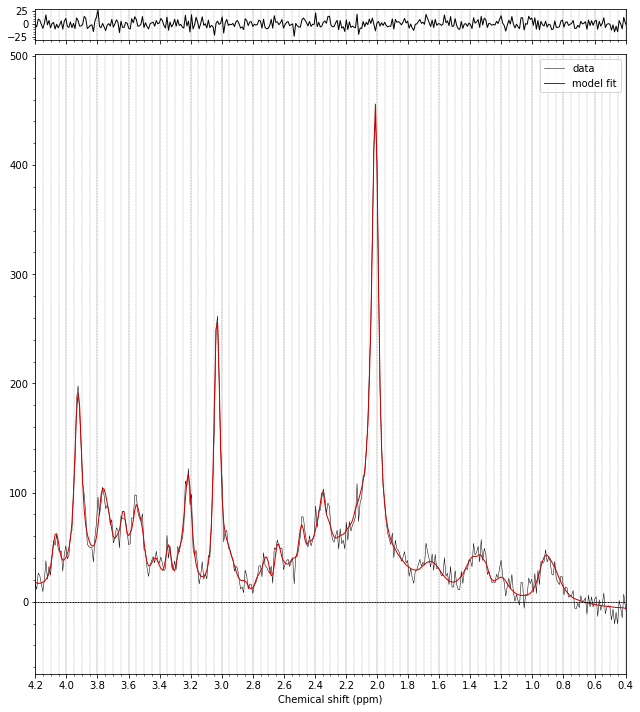

In [234]:
from fsl_mrs.utils.fitting import fit_FSLModel
from fsl_mrs.utils.misc import parse_metab_groups
from fsl_mrs.utils.plotting import plot_fit

test_dat = mrs_io.read_FID(out_dir / 'sub0_stim.nii.gz')

dat_1 = test_dat.mrs(basis=basis)[0]

fit_args = dict(ppmlim=(0.2, 4.2), baseline_order=0, metab_groups=parse_metab_groups(dat_1, 'Mac'))

res_1 = fit_FSLModel(dat_1, **fit_args)

_ = plot_fit(dat_1, res_1.pred, baseline=res_1.baseline)
